In [379]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')
print(os.get_exec_path())

['/home/tm_ba/miniconda3/envs/BA/bin', '/home/tm_ba/miniconda3/condabin', '/opt/ros/noetic/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin']


In [380]:
import pandas as pd
import os

def parse_and_merge_tables(file_paths):
    """
    Parses the tables from the given list of files and merges tables of the same kind.

    Args:
        file_paths (list): List of paths to the files containing the tables.

    Returns:
        dict: A dictionary where the keys are table names, and the values are merged DataFrames.
    """
    # Initialize a dictionary to store DataFrames with table names as keys
    merged_tables = {}
    to_delete = []

    for recording_idx, file_path in enumerate(file_paths):
        with open(file_path, 'r') as file:
            # Read the entire content of the file
            content = file.read()

        # Split the content by double newlines to separate the tables
        tables = content.strip().split('\n\n')

        for table in tables:
            # Split the table content by lines
            lines = table.strip().split('\n')

            # Extract the table name from the first line
            table_name = lines[0].strip()

            # Extract the Hz information (metadata) from the second line
            hz = lines[1].strip()

            # Parse the column headers and units from the next three lines
            group_headers = lines[2].split(',')  # Group headers (first row)
            column_headers = lines[3].split(',')  # Column names (second row)
            units = lines[4].split(',')  # Units (third row)

            # Create a list to hold the full column names
            columns = []
            current_group = ""

            # Construct the full column names using group headers, column names, and units
            for group_header, column_header, unit in zip(group_headers, column_headers, units):
                if group_header.strip():  # Update the current group if it's not empty
                    current_group = group_header.strip()
                    if ":" in current_group:
                        current_group = current_group.split(":")[1]
                full_column_name = ""
                if current_group:
                    full_column_name = f"{current_group}:"
                full_column_name += f"{column_header.strip()}"
        
                columns.append(full_column_name)
            

            # Parse the data rows starting from the 6th line onward
            data = [line.split(',') for line in lines[5:]]

            # Create a DataFrame for the current table
            df = pd.DataFrame(data, columns=columns)

            # Convert numeric columns to appropriate types where possible
            df = df.apply(pd.to_numeric)

            # Attach metadata (Hz information) to the DataFrame as an attribute
            df.attrs['hz'] = hz

            # Check for duplicate column names and handle them by renaming
            if len(df.columns) != len(set(df.columns)):
                # Automatically renames duplicate columns
                df.columns = pd.io.parsers.ParserBase({'names': df.columns})._maybe_dedup_names(df.columns)
                to_delete.append(file_path)

            if table_name == "Trajectories":
                wanted_columns = ["Frame", "shoulder", "elbow", "wrist", "ThumbTip"]
                columns = [col for col in columns if (":" not in col and col in wanted_columns) or (":" in col and col.split(":")[0] in wanted_columns)]

            df = df.loc[:, columns]

            # Add 'Sequence' column to track the file source
            df['Sequence'] = recording_idx

            # If the table has already been seen, merge the new data into the existing DataFrame
            if table_name in merged_tables:
                existing_df = merged_tables[table_name]

                # Align columns before concatenation
                merged_tables[table_name] = pd.concat([existing_df, df], ignore_index=True)
            else:
                merged_tables[table_name] = df

    # Optionally, remove files with duplicate column names
    for csv in to_delete:
        os.remove(csv)

    return merged_tables


In [381]:
data_directory  = "Mathew" 
data_paths = [os.path.join(data_directory, data_path) for data_path in os.listdir(data_directory)]
tables_dict = parse_and_merge_tables(data_paths)


In [382]:
# Display the tables in the dictionary
for table_name, df in tables_dict.items():
    print(f"Table Name: {table_name}")
    print(f"Hz: {df.attrs['hz']}")
    print(f"Columns: {df.columns}")
    os.makedirs('csv_new', exist_ok=True)
    df.to_csv(f"csv_new/{table_name}.csv", index=False)  # Save the DataFrame to a CSV file
    print("\n" + "-"*50 + "\n")  # Separator between tables

Table Name: Joints
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'HandOuter_Thumb:RX', 'HandOuter_Thumb:RY',
       'HandOuter_Thumb:RZ', 'LowerArm_HandOuter:RX', 'LowerArm_HandOuter:RY',
       'LowerArm_HandOuter:RZ', 'UpperArm_LowerArm:RX', 'UpperArm_LowerArm:RY',
       'UpperArm_LowerArm:RZ', 'World_UpperArm:RX', 'World_UpperArm:RY',
       'World_UpperArm:RZ', 'World_UpperArm:TX', 'World_UpperArm:TY',
       'World_UpperArm:TZ', 'Sequence'],
      dtype='object')

--------------------------------------------------

Table Name: Segments
Hz: 200
Columns: Index(['Frame', 'Sub Frame', 'HandOuter:RX', 'HandOuter:RY', 'HandOuter:RZ',
       'HandOuter:TX', 'HandOuter:TY', 'HandOuter:TZ', 'LowerArm:RX',
       'LowerArm:RY', 'LowerArm:RZ', 'LowerArm:TX', 'LowerArm:TY',
       'LowerArm:TZ', 'Thumb:RX', 'Thumb:RY', 'Thumb:RZ', 'Thumb:TX',
       'Thumb:TY', 'Thumb:TZ', 'UpperArm:RX', 'UpperArm:RY', 'UpperArm:RZ',
       'UpperArm:TX', 'UpperArm:TY', 'UpperArm:TZ', 'Sequence'],
      dtyp

In [383]:
trajectories = tables_dict["Trajectories"]
trajectories

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,424.573,31.46390,632.820,437.244,95.0522,303.700,326.770,203.019,98.6228,208.065,226.836,58.5300,0
1,2,424.260,31.44500,632.718,436.375,95.5444,304.092,324.475,203.747,100.3170,205.831,226.619,58.8733,0
2,3,424.073,31.44570,632.837,435.643,96.2625,304.070,NaN,NaN,NaN,203.393,225.856,59.2708,0
3,4,423.898,31.59660,632.891,434.516,96.9949,304.057,NaN,NaN,NaN,200.365,225.176,59.9573,0
4,5,423.604,31.65990,632.974,433.747,97.6751,303.587,NaN,NaN,NaN,197.646,224.697,60.5265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,472.782,-7.33897,652.253,554.699,35.5385,328.978,590.940,176.447,116.2500,553.403,289.602,36.5813,50
29036,485,472.814,-7.35831,652.198,554.922,35.4013,329.154,591.052,176.461,116.3110,553.230,289.540,36.6210,50
29037,486,472.883,-7.35738,652.159,555.211,35.2621,329.311,591.054,176.543,116.2950,553.066,289.457,36.4266,50
29038,487,472.944,-7.36919,652.078,555.527,35.0052,329.505,NaN,NaN,NaN,552.995,289.511,36.4619,50


/tmp/ipykernel_226220/2545848900.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sequence_counts.index, y=sequence_counts.values, palette='viridis')


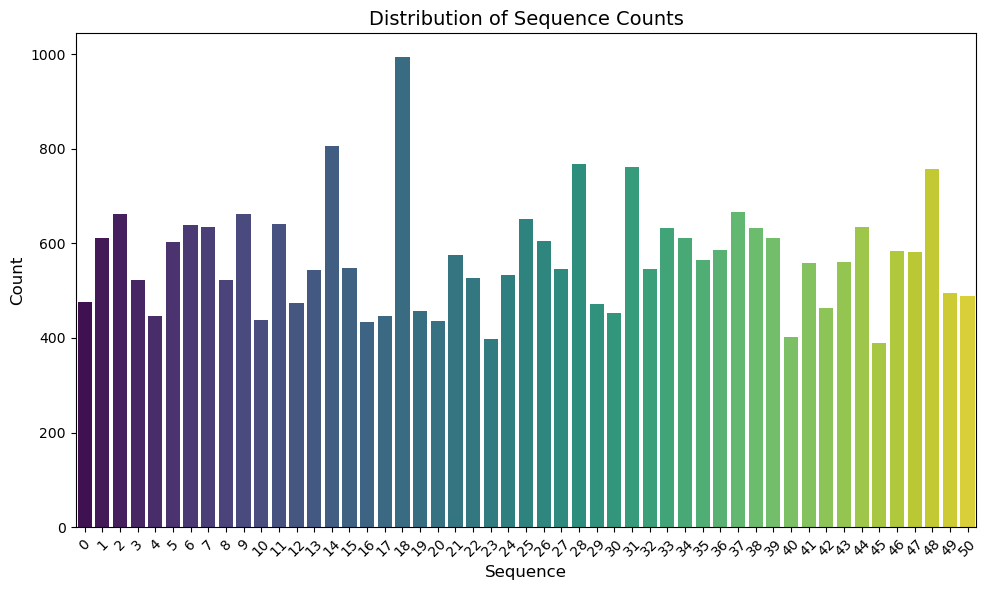

In [384]:

# Get the sequence counts
sequence_counts = trajectories["Sequence"].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sequence_counts.index, y=sequence_counts.values, palette='viridis')

# Add title and labels
plt.title('Distribution of Sequence Counts', fontsize=14)
plt.xlabel('Sequence', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate the x-axis labels if there are many sequences
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [385]:
num_landmarks = (trajectories.shape[1] - 2) // 3 
num_landmarks

4

In [386]:
def plot_joint_speeds(df, sequence_idx, max_frames=None):
    """
    Plots the speed of various joints over time for a specified sequence.

    Parameters:
    df (pd.DataFrame): DataFrame containing the trajectory data with columns for each joint's X, Y, Z positions.
    sequence_idx (int): The sequence index to filter the data and visualize.
    max_frames (int, optional): Maximum number of frames to display for clarity. If None, it will display all frames.

    Returns:
    None: Displays the plot.
    """
    # Step 1: Identify joint names based on column names containing ':X', ':Y', ':Z'
    joint_names = set([col.split(':')[0] for col in df.columns if ':' in col])

    # Step 2: Filter the data by the specified sequence index
    filtered_data = df[df["Sequence"] == sequence_idx].copy()

    # Step 3: Limit the number of frames for clarity if max_frames is specified
    if max_frames is not None:
        filtered_data = filtered_data.iloc[:max_frames]

    # Step 4: Calculate speed for each joint
    for joint in joint_names:
        x_col = f'{joint}:X'
        y_col = f'{joint}:Y'
        z_col = f'{joint}:Z'
        
        # Make sure the joint has X, Y, and Z columns before calculating speed
        if all(col in filtered_data.columns for col in [x_col, y_col, z_col]):
            filtered_data[f'{joint}_speed'] = np.sqrt(filtered_data[x_col].diff()**2 + 
                                           filtered_data[y_col].diff()**2 + 
                                           filtered_data[z_col].diff()**2)

    # Step 5: Plot the speeds of each joint
    plt.figure(figsize=(12, 8))
    
    # Plot all calculated speed columns
    for joint in joint_names:
        speed_col = f'{joint}_speed'
        if speed_col in filtered_data.columns:  # Check if the speed column exists
            plt.plot(filtered_data.index, filtered_data[speed_col], label=f'{joint} Speed')
    
    # Add labels and title
    plt.title(f'Speed of Various Joints Over Time (Sequence {sequence_idx})')
    plt.xlabel('Frame')
    plt.ylabel('Speed (units/frame)')
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

In [403]:
recording_idx = 20

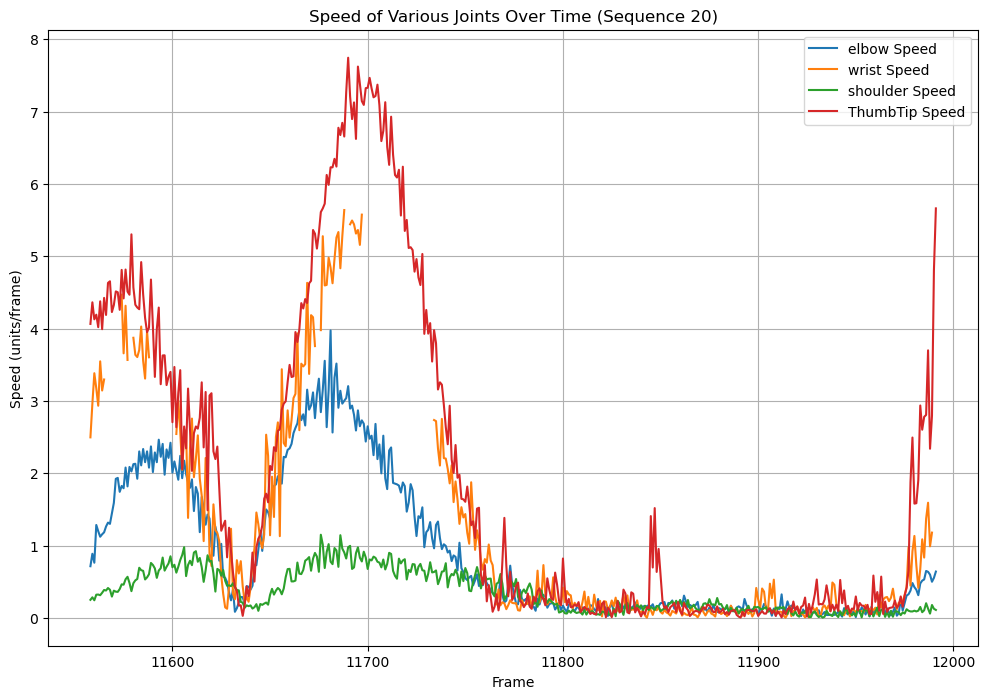

In [404]:
plot_joint_speeds(trajectories, recording_idx)


### Filling NaN values

In [405]:
trajectories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       29040 non-null  int64  
 1   shoulder:X  29040 non-null  float64
 2   shoulder:Y  29040 non-null  float64
 3   shoulder:Z  29040 non-null  float64
 4   elbow:X     28855 non-null  float64
 5   elbow:Y     28855 non-null  float64
 6   elbow:Z     28855 non-null  float64
 7   wrist:X     21929 non-null  float64
 8   wrist:Y     21929 non-null  float64
 9   wrist:Z     21929 non-null  float64
 10  ThumbTip:X  28985 non-null  float64
 11  ThumbTip:Y  28985 non-null  float64
 12  ThumbTip:Z  28985 non-null  float64
 13  Sequence    29040 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.1 MB


In [460]:
trajectories_interpolated = trajectories.copy()

for sequence in trajectories["Sequence"].drop_duplicates():
  
    trajectories_interpolated[trajectories_interpolated["Sequence"] == sequence] = trajectories_interpolated[trajectories_interpolated["Sequence"] == sequence].interpolate(method='linear', limit_direction="both")


# Display the number of NaN values in each column after interpolation
print("Remaining NaN values in each column after interpolation:")
print(trajectories_interpolated.isna().sum())


Remaining NaN values in each column after interpolation:
Frame         0
shoulder:X    0
shoulder:Y    0
shoulder:Z    0
elbow:X       0
elbow:Y       0
elbow:Z       0
wrist:X       0
wrist:Y       0
wrist:Z       0
ThumbTip:X    0
ThumbTip:Y    0
ThumbTip:Z    0
Sequence      0
dtype: int64


In [461]:
trajectories_interpolated[trajectories_interpolated["Sequence"] == 10]

,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
5777,1,433.257,25.94140,636.579,446.079,96.1175,307.585,296.813,218.434,124.319,243.561,277.057,66.9528,10
5778,2,433.026,26.03820,636.504,445.154,96.5215,307.336,296.813,218.434,124.319,239.350,276.398,67.8125,10
5779,3,432.704,26.03570,636.345,444.320,96.9313,307.213,296.813,218.434,124.319,235.942,276.499,70.0076,10
5780,4,432.423,26.11300,636.347,443.482,97.4989,307.048,296.813,218.434,124.319,232.011,275.962,72.6327,10
5781,5,432.116,26.33690,636.295,442.674,98.2479,307.396,296.813,218.434,124.319,228.578,276.036,74.9239,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,433,478.181,-6.78143,635.781,557.088,37.8702,321.603,587.598,188.585,111.592,549.871,300.157,33.1626,10
6210,434,478.191,-6.78501,635.785,557.100,37.8758,321.610,587.593,188.618,111.645,550.445,300.336,34.0615,10
6211,435,478.160,-6.80879,635.800,557.147,37.7945,321.711,587.590,188.640,111.557,550.172,300.345,33.8011,10
6212,436,478.171,-6.78700,635.760,557.228,37.8177,321.666,587.643,188.639,111.674,549.877,300.196,33.1641,10


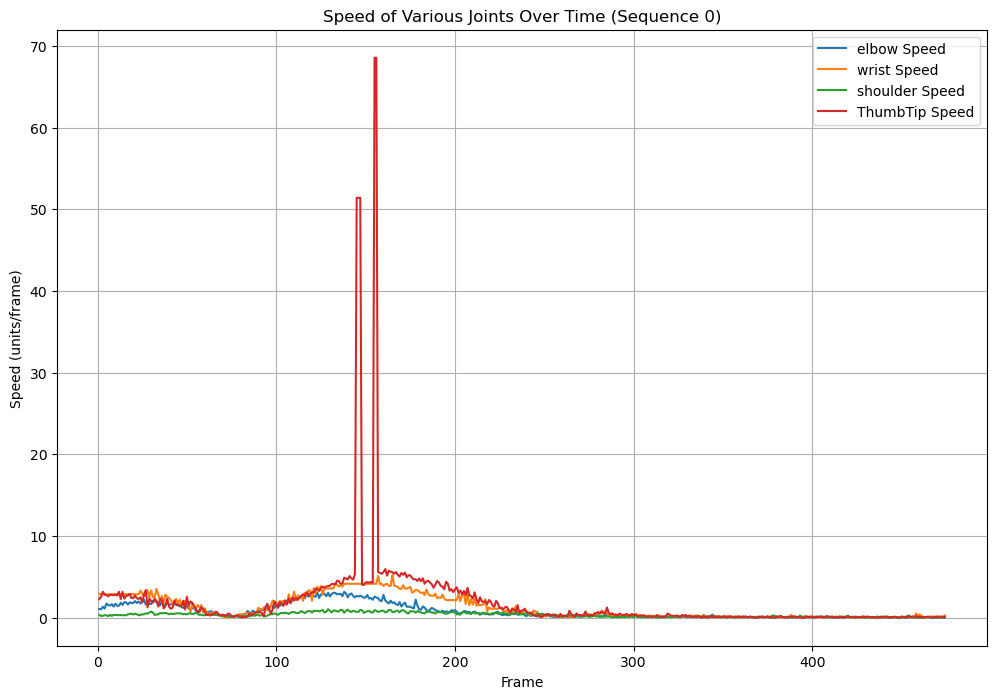

In [516]:
plot_joint_speeds(trajectories_interpolated, 0)

In [567]:
import pandas as pd
import numpy as np

def clean_motion_tracking_data(df):
    # Step 1: Identify columns that belong to joints (columns with ":")
    joint_columns = [col for col in df.columns if ':' in col]
    
    # Create a copy of the DataFrame to avoid modifying the original data
    cleaned_df = df.copy()

    # Velocity-based outlier detection and correction
    for joint in set(col.split(':')[0] for col in joint_columns):  # process each joint independently
        for axis in ['X', 'Y', 'Z']:  # process each axis (X, Y, Z) of the joint
            column_name = f'{joint}:{axis}'
            if column_name in cleaned_df.columns:
                # Step 2: Calculate the velocity as the first difference
                velocity = cleaned_df[column_name].diff().abs()

                # Step 3: Detect outliers using a threshold (e.g., using z-score or IQR for velocity)
                # Here, we are using 3 * standard deviation as a simple threshold for outliers
                velocity_mean = velocity.mean()
                velocity_std = velocity.std()
                outlier_threshold = velocity_mean + 3 * velocity_std

                # Identify where the velocity exceeds the threshold (mark those points as outliers)
                outliers = velocity > outlier_threshold
                

                # Step 4: Interpolation and correction of outliers
                # We replace outliers by interpolating between valid values
                if "ThumbTip" in column_name:
                    print(cleaned_df[column_name].iloc[140:160])
                cleaned_df.loc[outliers, column_name] = np.nan
                if "ThumbTip" in column_name:
                    print(cleaned_df[column_name].iloc[140:160])
                cleaned_df[column_name] = cleaned_df[column_name].interpolate(method='linear', limit_direction="both")
                if "ThumbTip" in column_name:
                    print("INTERPOLATED",cleaned_df[column_name].iloc[140:160])

    return cleaned_df


In [568]:
trajectories_cleaned = clean_motion_tracking_data(trajectories_interpolated)

140    209.786000
141    214.665000
142    219.391000
143    223.962000
144    229.141000
145    272.281667
146    315.422333
147    358.563000
148    362.421000
149    366.286000
150    370.510000
151    374.803000
152    379.001000
153    383.341000
154    387.541000
155    339.836500
156    292.132000
157    297.574000
158    302.978000
159    308.287000
Name: ThumbTip:X, dtype: float64
140    209.786
141    214.665
142    219.391
143    223.962
144    229.141
145        NaN
146        NaN
147        NaN
148    362.421
149    366.286
150    370.510
151    374.803
152    379.001
153    383.341
154    387.541
155        NaN
156        NaN
157        NaN
158        NaN
159    308.287
Name: ThumbTip:X, dtype: float64
INTERPOLATED 140    209.7860
141    214.6650
142    219.3910
143    223.9620
144    229.1410
145    262.4610
146    295.7810
147    329.1010
148    362.4210
149    366.2860
150    370.5100
151    374.8030
152    379.0010
153    383.3410
154    387.5410
155    371.6902
156  

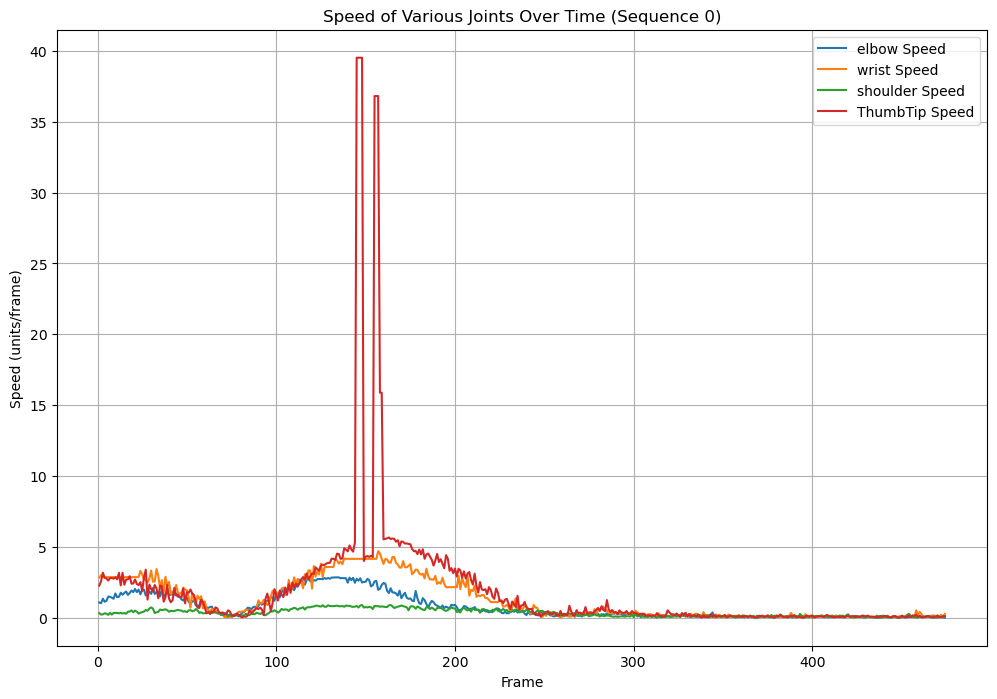

In [569]:
plot_joint_speeds(trajectories_cleaned, 0)


In [330]:
trajectories_interpolated[trajectories_interpolated["Sequence"] == 10][[col for col in trajectories.columns if "wrist" in col]][:30] # 5792

,wrist:X,wrist:Y,wrist:Z,wrist_speed
5777,562.310187,166.643687,95.218344,NaN
5778,544.610375,170.096375,97.158388,18.137480
5779,526.910562,173.549062,99.098431,18.137480
5780,509.210750,177.001750,101.038475,18.137480
5781,491.510937,180.454438,102.978519,18.137480
5782,473.811125,183.907125,104.918563,18.137480
5783,456.111312,187.359813,106.858606,18.137480
5784,438.411500,190.812500,108.798650,18.137480
5785,420.711687,194.265187,110.738694,18.137480
5786,403.011875,197.717875,112.678738,18.137480


In [129]:
speeds = []
for i in range(1, trajectories_interpolated.shape[0]):
    speed_frame = []
    for j in range(2, num_landmarks * 3 + 2, 3):
        dx = trajectories_interpolated.iloc[i, j] - trajectories_interpolated.iloc[i-1, j]
        dy = trajectories_interpolated.iloc[i, j + 1] - trajectories_interpolated.iloc[i-1, j + 1]
        dz = trajectories_interpolated.iloc[i, j + 2] - trajectories_interpolated.iloc[i-1, j + 2]
        speed = np.sqrt(dx**2 + dy**2 + dz**2)
        speed_frame.append(speed)
    speed_frame.append(trajectories_interpolated.iloc[i]["Sequence"])
    speeds.append(speed_frame)

speeds_df = pd.DataFrame(speeds, columns=[f'{trajectories_interpolated.columns[2 + i*3].split(":")[0]}' for i in range(num_landmarks)] + ["Sequence"])
speeds_df.to_csv('./csv_new/Speeds.csv', index=False)

In [124]:
# Schritt 1: Berechnen des IQR und Ausreißer-Grenzen festlegen
Q1 = speeds_df.quantile(0.25)
Q3 = speeds_df.quantile(0.75)
IQR = Q3 - Q1

# Festlegung der Grenzen, um Ausreißer zu entfernen (1.5-facher IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Schritt 2: Entfernen der Ausreißer
filtered_speeds_df = speeds_df[~((speeds_df < lower_bound) | (speeds_df > upper_bound)).any(axis=1)]


In [125]:
def moving_average(data, window_size):
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

# Apply the moving average to each column in the DataFrame
window_size = 10  # Adjust the window size as needed
smoothed_speeds_df = filtered_speeds_df.apply(moving_average, window_size=window_size)

In [92]:
visualized_speeds_df = smoothed_speeds_df[smoothed_speeds_df["Sequence"] == recording_idx].drop("Sequence", axis=1)
visualized_speeds_df

,shoulder,elbow,wrist,ThumbTip
11563,0.774789,2.766821,4.166741,1.574364
11564,0.820653,2.748705,4.121630,1.635333
11565,0.905860,2.830166,4.123503,1.508793
11566,0.980842,2.983828,4.032386,1.435450
11567,1.060485,3.019382,4.092755,1.379664
...,...,...,...,...
11979,0.094712,0.695841,1.200996,1.142510
11980,0.084602,0.735056,1.348128,1.349486
11981,0.097182,0.779641,1.501368,1.558904
11982,0.102991,0.808670,1.573231,1.701265


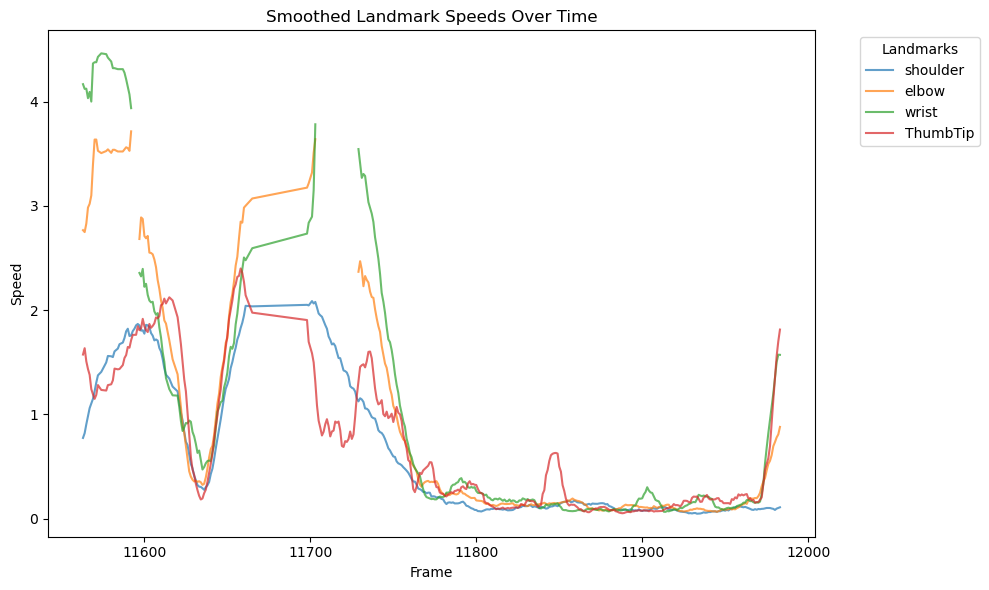

In [93]:
# Plotting smoothed speeds with transparency
plt.figure(figsize=(10, 6))
for column in visualized_speeds_df.columns:
    plt.plot(visualized_speeds_df.index, visualized_speeds_df[column], label=column, alpha=0.7)  # Adjust alpha for transparency

plt.title('Smoothed Landmark Speeds Over Time')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend(title='Landmarks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
trajectories.isna().sum().sum()

22053

In [79]:
pd.read_csv('csv_new/Trajectories.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       29040 non-null  int64  
 1   shoulder:X  29040 non-null  float64
 2   shoulder:Y  29040 non-null  float64
 3   shoulder:Z  29040 non-null  float64
 4   elbow:X     28855 non-null  float64
 5   elbow:Y     28855 non-null  float64
 6   elbow:Z     28855 non-null  float64
 7   wrist:X     21929 non-null  float64
 8   wrist:Y     21929 non-null  float64
 9   wrist:Z     21929 non-null  float64
 10  ThumbTip:X  28985 non-null  float64
 11  ThumbTip:Y  28985 non-null  float64
 12  ThumbTip:Z  28985 non-null  float64
 13  Sequence    29040 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.1 MB


In [81]:
import pandas as pd
import numpy as np

def read_and_process_data(file_path):
    # Load data
    data = pd.read_csv(file_path)

    # Preserve the 'Sequence' column (do not include it in the outlier processing)
    sequence_col = data['Sequence']
    
    # Calculate differences between consecutive frames for all columns except 'Frame' and 'Sub Frame'
    position_columns = [col for col in data.columns if col not in ['Frame', 'Sub Frame', 'Sequence']]  # Exclude 'Sequence'
    differences = data[position_columns].diff().abs()

    # Identify outliers using the IQR method
    Q1 = differences.quantile(0.25)
    Q3 = differences.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 1.5 * IQR

    # Create a mask for outliers
    outliers = (differences > outlier_threshold)

    # Interpolate outliers and handle NaNs
    for col in position_columns:
        # Mark outliers as NaN
        data.loc[outliers[col], col] = np.nan
        
        # Remove only the outliers at the beginning of the dataset (consecutive NaNs at the start)

        # Interpolate NaN values (including consecutive NaNs) using linear interpolation
        data[col] = data[col].interpolate(method='linear', limit_direction='both')
        
        # Optional: Fill any remaining NaNs at the start or end of the series using forward and backward fill
        data[col] = data[col].ffill().bfill()

    # Restore the 'Sequence' column after processing
    data['Sequence'] = sequence_col.iloc[data.index].reset_index(drop=True)

    return data

# Usage
processed_data = read_and_process_data('csv_new/Trajectories.csv')
processed_data.to_csv('csv_new/processed_Trajectories.csv', index=False)


In [83]:
processed_data.value_counts("Sequence")

Sequence
18    994
14    805
28    767
31    762
48    758
37    666
2     663
9     661
25    651
11    640
6     638
7     635
44    634
33    632
38    632
1     612
39    612
34    611
26    605
5     602
36    585
46    583
47    582
21    575
35    565
43    560
41    558
15    548
27    545
32    545
13    544
24    534
22    526
8     523
3     522
49    494
50    488
0     475
12    474
29    471
42    464
19    457
30    452
17    447
4     446
10    437
20    435
16    434
40    403
23    398
45    390
Name: count, dtype: int64

In [84]:
speeds = []
for i in range(1, processed_data.shape[0]):
    speed_frame = []
    for j in range(2, num_landmarks * 3 + 2, 3):
        dx = processed_data.iloc[i, j] - processed_data.iloc[i-1, j]
        dy = processed_data.iloc[i, j + 1] - processed_data.iloc[i-1, j + 1]
        dz = processed_data.iloc[i, j + 2] - processed_data.iloc[i-1, j + 2]
        speed = np.sqrt(dx**2 + dy**2 + dz**2)
        speed_frame.append(speed)
    speed_frame.append(processed_data.iloc[i]["Sequence"])
    speeds.append(speed_frame)

processed_speeds_df = pd.DataFrame(speeds, columns=[f'{processed_data.columns[2 + i*3].split(":")[1]}' for i in range(num_landmarks)] + ["Recording"])


KeyError: 'Recording'

In [85]:
visualized_speeds_df = processed_speeds_df.drop("Recording", axis=1)
visualized_speeds_df

NameError: name 'processed_speeds_df' is not defined

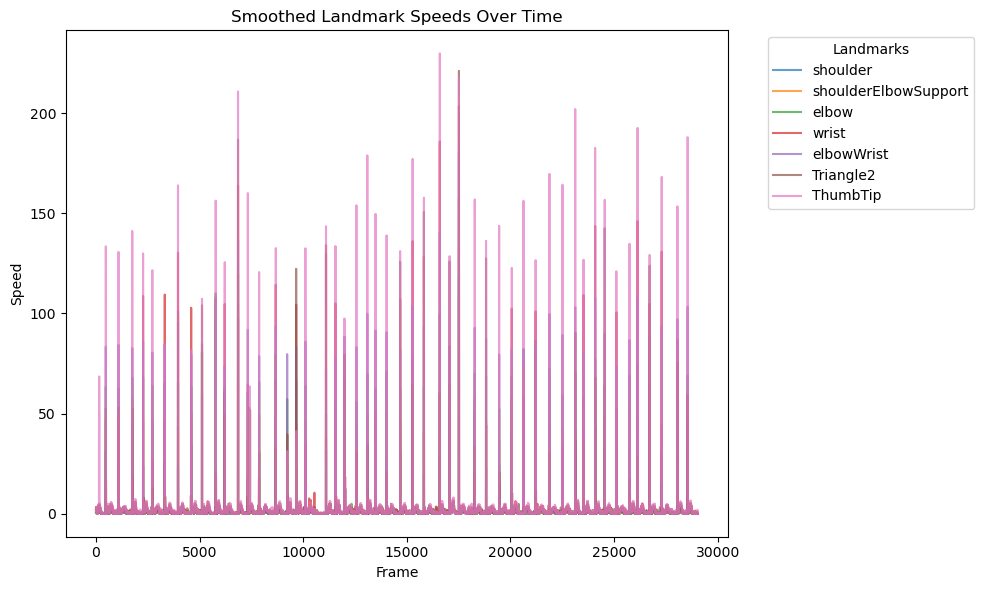

In [502]:
# Plotting smoothed speeds with transparency
plt.figure(figsize=(10, 6))
for column in visualized_speeds_df.columns:
    plt.plot(visualized_speeds_df.index, visualized_speeds_df[column], label=column, alpha=0.7)  # Adjust alpha for transparency

plt.title('Smoothed Landmark Speeds Over Time')
plt.xlabel('Frame')
plt.ylabel('Speed')
plt.legend(title='Landmarks', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [465]:
!jupyter nbconvert --to script Code/preprocessing/read_data.ipynb


[NbConvertApp] Converting notebook Code/preprocessing/read_data.ipynb to script
[NbConvertApp] Writing 10692 bytes to Code/preprocessing/read_data.py


In [466]:
processed_data.rename(columns={"Recording": "Sequence"}).drop(columns=["Sub Frame"]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Frame                               29040 non-null  int64  
 1   Mathew:shoulder:X (mm)              29040 non-null  float64
 2   Mathew:shoulder:Y (mm)              29040 non-null  float64
 3   Mathew:shoulder:Z (mm)              29040 non-null  float64
 4   Mathew:shoulderElbowSupport:X (mm)  29040 non-null  float64
 5   Mathew:shoulderElbowSupport:Y (mm)  29040 non-null  float64
 6   Mathew:shoulderElbowSupport:Z (mm)  29040 non-null  float64
 7   Mathew:elbow:X (mm)                 29040 non-null  float64
 8   Mathew:elbow:Y (mm)                 29040 non-null  float64
 9   Mathew:elbow:Z (mm)                 29040 non-null  float64
 10  Mathew:wrist:X (mm)                 29040 non-null  float64
 11  Mathew:wrist:Y (mm)                 29040